In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from scipy.stats import zscore
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from itertools import cycle
import vips
import random
from collections import Counter
from tqdm import tqdm

In [8]:
#train_raw_counts = pd.read_csv('../data/BAL/Reseq_ALL/counts_reseq.csv', sep='\t', 
#                     index_col='sample_id')

train_fpkm0 = pd.read_csv("../data/BAL/new_counts_fpkm_R.txt",sep='\t').T
train_meta = pd.read_csv('../data/BAL/Reseq_ALL/meta_reseq.csv', sep='\t', index_col='sample_id')

test_fpkm0 = pd.read_csv('../data/BAL/Run0/granges.fpkms.txt', sep='\t').T
test_meta = pd.read_csv('../data/BAL/meta_r0.csv', sep='\t', index_col=0)

# Pre-processing
### Require X % of samples to have Y gene greater than 0

In [5]:
test_fpkm0.shape

(32, 60128)

In [45]:
plt.hist?

In [52]:
np.logspace?

In [122]:
d = train_fpkm0.ix[2,:].map(lambda x: np.log10(x+1))
dtest = test_fpkm0.ix[2,:].map(lambda x: np.log10(x+1))

In [123]:
np.max(d), np.min(d)

(4.200582018598751, 0.0)

In [ ]:
def get_max

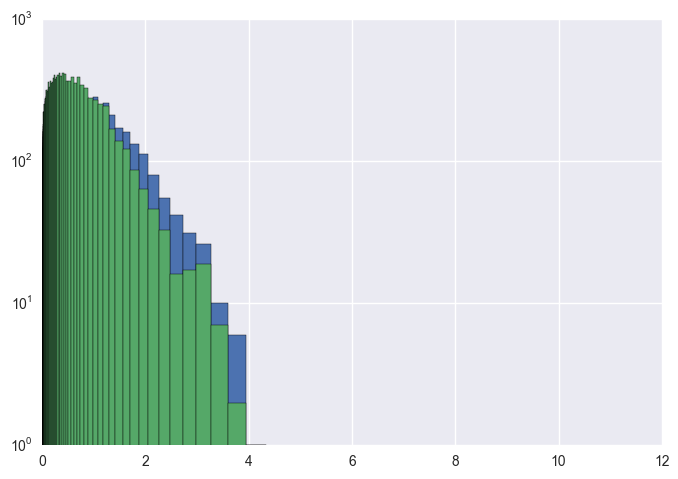

In [128]:
bins = np.logspace(-3,1,num=100)
#bins = 50
b = plt.hist(d, bins=bins, log=True)
_ = plt.hist(dtest, bins=bins, log=True)
#plt.gca().set_xscale("log")
plt.show()

In [113]:
b[0]

array([   1.,    3.,    3.,    5.,    3.,    6.,    8.,    6.,    5.,
          4.,    4.,    7.,    9.,    7.,    9.,    9.,    6.,   13.,
          5.,    8.,   16.,   13.,   13.,   12.,   13.,   17.,   18.,
         15.,   23.,   12.,   24.,   24.,   28.,   38.,   27.,   23.,
         19.,   24.,   20.,   30.,   36.,   39.,   33.,   32.,   37.,
         48.,   46.,   49.,   59.,   60.,   61.,   65.,   76.,   82.,
         89.,   91.,  115.,   92.,  107.,  114.,  123.,  146.,  140.,
        152.,  157.,  185.,  165.,  215.,  229.,  231.,  195.,  237.,
        247.,  265.,  230.,  265.,  281.,  277.,  274.,  314.,  278.,
        284.,  288.,  292.,  272.,  286.,  247.,  288.,  241.,  245.,
        213.,  163.,  165.,  129.,  104.,   80.,   58.,   38.,   28.])

In [112]:
np.argsort(b[0])

array([ 0,  1,  2,  4, 10,  9,  8, 18,  3,  5, 16,  7, 11, 13,  6, 19, 12,
       14, 15, 29, 23, 24, 22, 17, 21, 27, 20, 25, 26, 36, 38, 35, 28, 30,
       31, 37, 34, 98, 32, 39, 43, 42, 40, 44, 97, 33, 41, 46, 45, 47, 96,
       48, 49, 50, 51, 52, 95, 53, 54, 55, 57, 94, 58, 59, 56, 60, 93, 62,
       61, 63, 64, 91, 92, 66, 65, 70, 90, 67, 68, 74, 69, 71, 88, 89, 72,
       86, 73, 75, 84, 78, 77, 80, 76, 81, 85, 82, 87, 83, 79])

In [61]:
c = cycle(range(10))

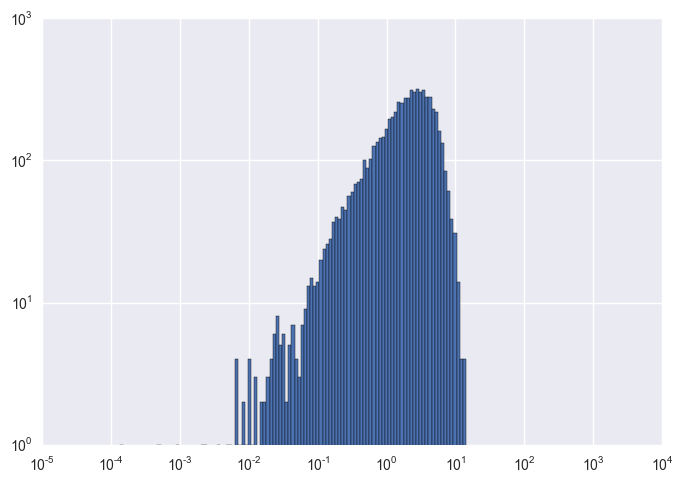

In [78]:
#for i in train_fpkm0

d = 
_ = plt.hist(np.log2(train_fpkm0.ix[c.next(),:]), bins=np.logspace(-5, 4, num=200), log=True)
plt.gca().set_xscale("log")
plt.show()

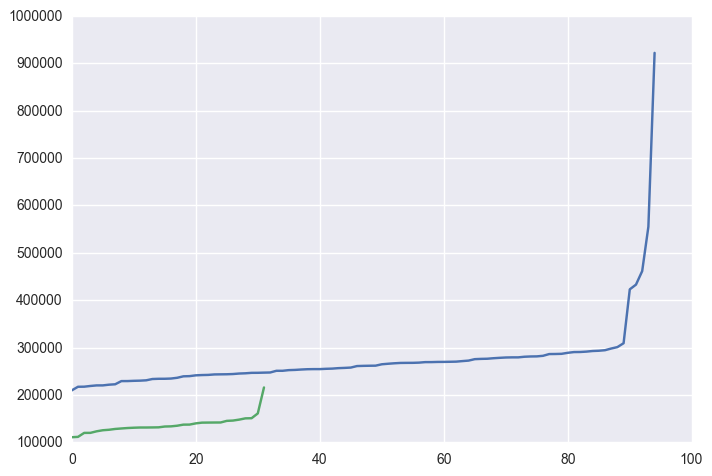

In [129]:
plt.plot(sorted(train_fpkm0.apply(lambda x: sum(x), axis=1)))
plt.plot(sorted(test_fpkm0.apply(lambda x: sum(x), axis=1)))

In [ ]:
min_uniques = 4e6
min_gene_count = 10 ## All genes from all samples must have 10 counts
## AM
def filter_norm(df, meta, celltype, min_gene_count=0, min_uniques=0):
    meta['Norm_Factor'] = meta['Uniquely mapped reads number'].map(lambda x: float(x) / np.median(meta['Uniquely mapped reads number']))
    bal_dict = dict(zip(meta.index,meta['Norm_Factor']))
    samples_min_unique = meta[meta['Uniquely mapped reads number'] > min_uniques].index
    df = df.ix[samples_min_unique].T
    for i in df.columns:
        norm_fac = meta.loc[i,'Norm_Factor']
        df[i] = df[i].map(lambda x: float(x)/norm_fac)
    df = df.T
    df = df.loc[:, df.min(axis=0) > min_gene_count]
    df = df.apply(lambda x: np.log2(x + 1))
    dfm = meta.ix[df.index]
    return df, dfm

In [12]:
## Enforce minimum percentage of samples that have > min_count
def check_min_percent(df, min_percent, min_count=0):
    train_cols = []
    for gene in df.columns:
        percent_above_zero = float(len([x for x in df[gene].values if x > min_count]))/len(df[gene].values)*100
        if percent_above_zero >= min_percent:
            train_cols.append(gene)
    return df[train_cols]

### Log transform

### VARIABLE - LogX

In [9]:
train_fpkm = train_fpkm0.apply(lambda x: np.log2(x + 1))
test_fpkm = test_fpkm0.apply(lambda x: np.log2(x + 1))

### remove genes with very low counts

In [17]:
min_percent, min_count = 15, 0
train_fpkm = check_min_percent(train_fpkm, min_percent=min_percent, min_count=min_count)
test_fpkm = check_min_percent(test_fpkm, min_percent=min_percent, min_count=min_count)

In [18]:
train_fpkm.shape

(95, 11957)

## Require that genes used to build model are also present in test data

In [14]:
train_fpkm = train_fpkm[[col for col in train_fpkm.columns if col in test_fpkm.columns]]

In [16]:
train_fpkm.shape

(95, 11957)

 - It matters how many genes are in the training data, as the model is built on that data
 - It doesn't matter how many genes are in the test data, as only a subset of genes are used for testing, not modeling.

In [139]:
test_fpkm.to_csv("../data/BAL/test_fpkm_minfilter0_log2.csv", sep='\t')

In [140]:
train_fpkm.to_csv("../data/BAL/train_fpkm_minfilter0_log2.csv", sep='\t')

In [137]:
print test_fpkm.shape, test_meta.shape
print train_fpkm.shape, train_meta.shape

(32, 26081) (32, 2)
(95, 11957) (95, 32)


In [133]:
test_fpkm.shape

(32, 26)

### In this study we have significantly more negative than positive samples
### The function geteven_xy() returns an even number of neg and pos
   - sampling = 'up' means that a random number of pos samples are added to make up the difference (there are duplicate pos. samples)
   - sampling = 'down' means that a random number of neg. samples are removed (there are no duplicates, but the total number of samples is far fewer than when upsampling). 

In [9]:
test_meta['CellType'].value_counts()

AM       20
CD163    12
Name: CellType, dtype: int64

In [10]:
train_meta['CellType'].value_counts()

AM       49
CD163    46
Name: CellType, dtype: int64

In [11]:
def geteven_xy(df, dfm, celltype, norm=False):
    dfm = dfm[dfm['CellType']==celltype]
    df = df.ix[dfm.index]    
    df = check_min_percent(df, min_percent=min_percent, min_count=min_count)

    genes = df.columns
    if norm=='zsc': 
        df = df.apply(lambda x: zscore(x))
    X = np.array(df)
    y = dfm['Pneum'].values
    return X,y, genes, df, dfm

In [24]:
def get_accuracy_stats(celltype, n_top_genes, norm=False, random_genes=False):
    
    
    ### TRAINING
    #################
    
    # Get training data
    X, y, genes, df, dfm = geteven_xy(train_fpkm, train_meta, celltype=celltype, norm=norm)

    # Cross-validation (leave-one-out)
    neg_err, pos_err, Q2, neg_accuracy_train, pos_accuracy_train, vip_inds = calc_metrics(X, y, 
                                                        n_pcs=5, n_top_genes=n_top_genes)
    print "Model = ", celltype
    print "N_Top_Genes = ", n_top_genes
    print "Normalization = ", norm
    print "Q Squared: {} \n".format(Q2)

    num_neg_correct = sum([(e < 0.5) for e in neg_err])
    print "Negative train: {0:.2f} ({1}/{2}) ".format(neg_accuracy_train, num_neg_correct, len(neg_err))

    num_pos_correct = sum([(e < 0.5) for e in pos_err])
    print "Positive train: {0:.2f} ({1}/{2}) ".format(pos_accuracy_train, num_pos_correct, len(pos_err))
    
    ## Get most common genes from each LOO model
    all_vips = [g for m in vip_inds for g in m]
    c = Counter(all_vips)
    #return c
    top_inds = [i[0] for i in c.most_common(n_top_genes)]
    top_genes_train = [genes[i] for i in top_inds]

    if random_genes:
        top_genes_train = np.random.choice(genes, n_top_genes)
        print "\nGenes for testing are RANDOM\n"
    
    #print top_genes_train
    
    ### Build final model based on those genes (avoid overfitting with genes that are not common)
    pls = PLSRegression(5, scale=True)
    X_train = np.array(df[top_genes_train])
    y_train = np.array(dfm['Pneum'])
    pls.fit(X_train, y_train)
    y_train_pred = pls.predict(X_train)
    
    ### TESTING
    ###############
    
    X_test, y_test, genes_test, df_test, dfm_test = geteven_xy(test_fpkm, 
                        test_meta, celltype=celltype, norm=norm)

    X_test = np.array(df_test[top_genes_train])
    #X_test = np.array(df_test.ix[:,100:200])
    y_pred = pls.predict(X_test)

    neg_err = [float(abs(y_pred[i]-y_test[i])) for i in range(len(y_pred)) if y_test[i]==0]
    num_neg_correct = sum([(e < 0.5) for e in neg_err])
    neg_accuracy_test = float(num_neg_correct) / len(neg_err)
    print "Negative test: {0:.2f} ({1}/{2}) ".format(neg_accuracy_test, num_neg_correct, len(neg_err))

    pos_err = [float(abs(y_pred[i]-y_test[i])) for i in range(len(y_pred)) if y_test[i]==1]
    num_pos_correct = sum([(e < 0.5) for e in pos_err])
    pos_accuracy_test = float(num_pos_correct) / len(pos_err)
    print "Positive test: {0:.2f} ({1}/{2}) ".format(pos_accuracy_test, num_pos_correct, len(pos_err))

    return top_genes_train, df[top_genes_train], dfm, df_test[top_genes_train], dfm_test
    #neg_accuracy_train, neg_accuracy_test, pos_accuracy_train, pos_accuracy_test

# CD163+ predictions, clustering

In [32]:
top_genes_train, df_train_top, dfm_train, df_test_top, dfm_test = get_accuracy_stats(celltype='CD163', n_top_genes=10, norm='zsc', random_genes=False)

Model =  CD163
N_Top_Genes =  10
Normalization =  zsc
Q Squared: -0.115544471588 

Negative train: 0.90 (28/31) 
Positive train: 0.27 (4/15) 
Negative test: 0.80 (4/5) 
Positive test: 0.43 (3/7) 


## Train clustering

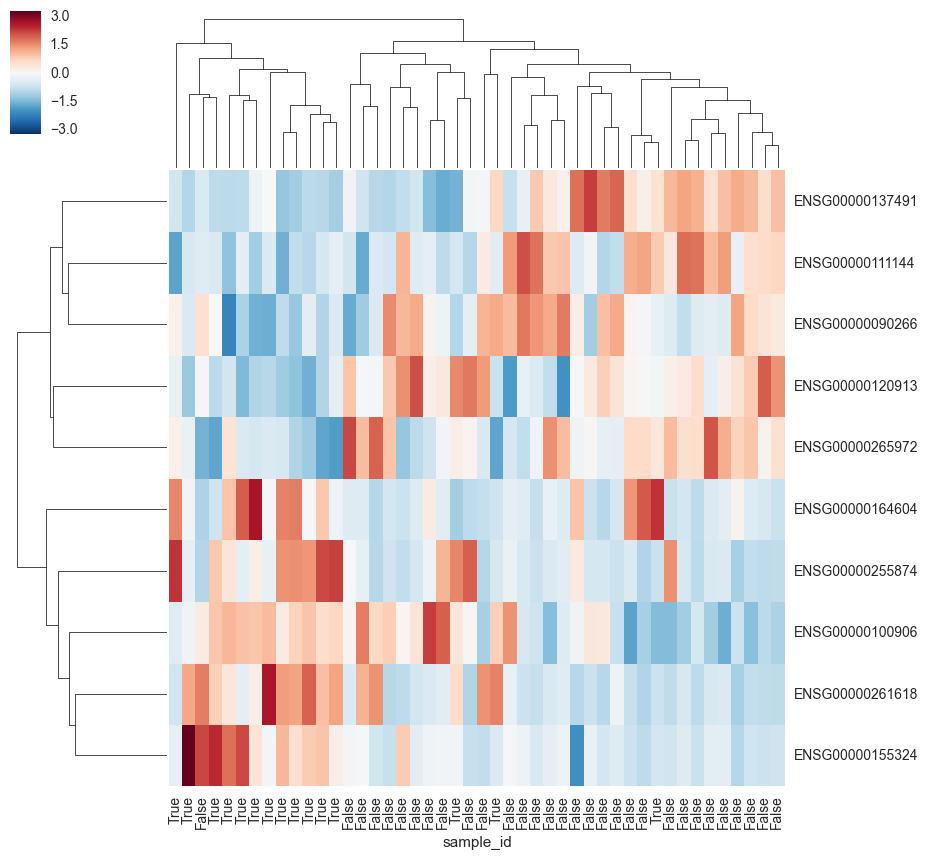

In [33]:
plot_cluster(df_train_top, dfm_train)

## Test clustering

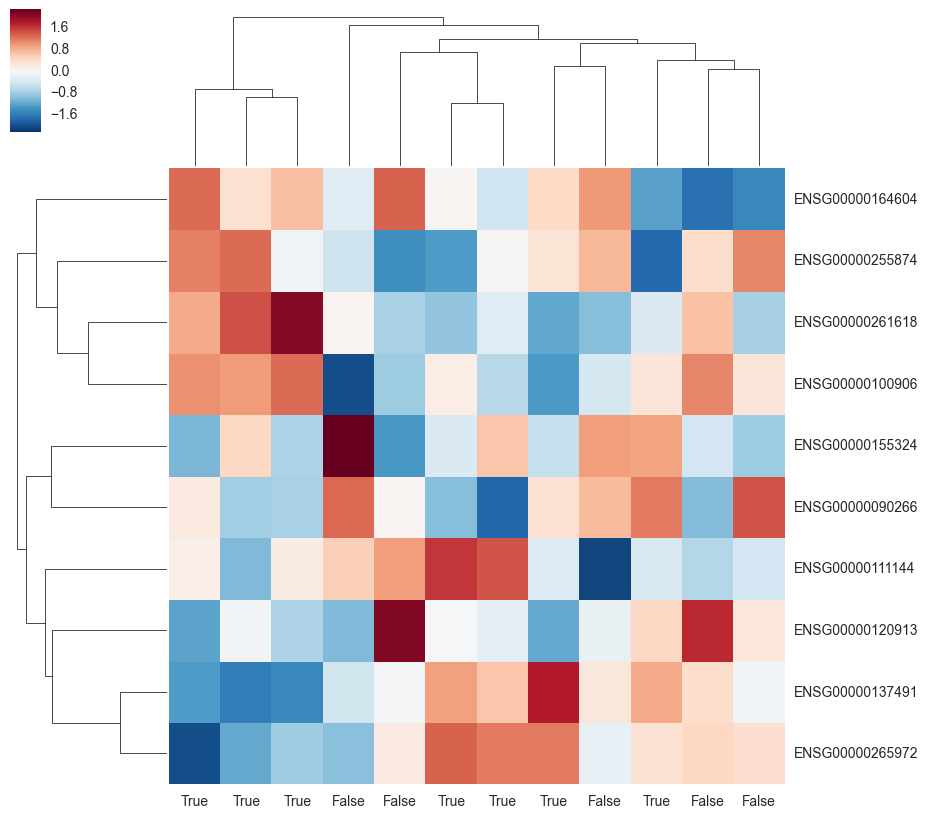

In [34]:
plot_cluster(df_test_top, dfm_test)

# AM predictions, clustering

In [38]:
top_genes_train, df_train_top, dfm_train, df_test_top, dfm_test = get_accuracy_stats(celltype='AM', n_top_genes=120, norm='zsc', random_genes=False)

Model =  AM
N_Top_Genes =  120
Normalization =  zsc
Q Squared: -0.427839845177 

Negative train: 0.63 (19/30) 
Positive train: 0.05 (1/19) 
Negative test: 0.93 (13/14) 
Positive test: 0.67 (4/6) 


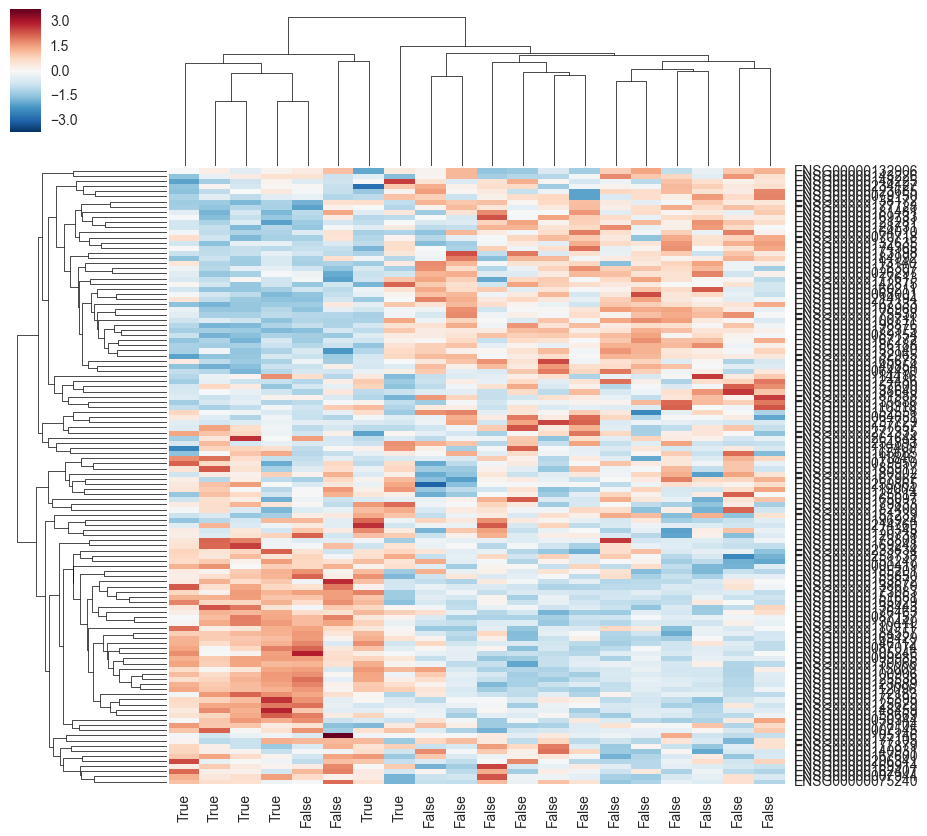

In [39]:
plot_cluster(df_test_top, dfm_test)

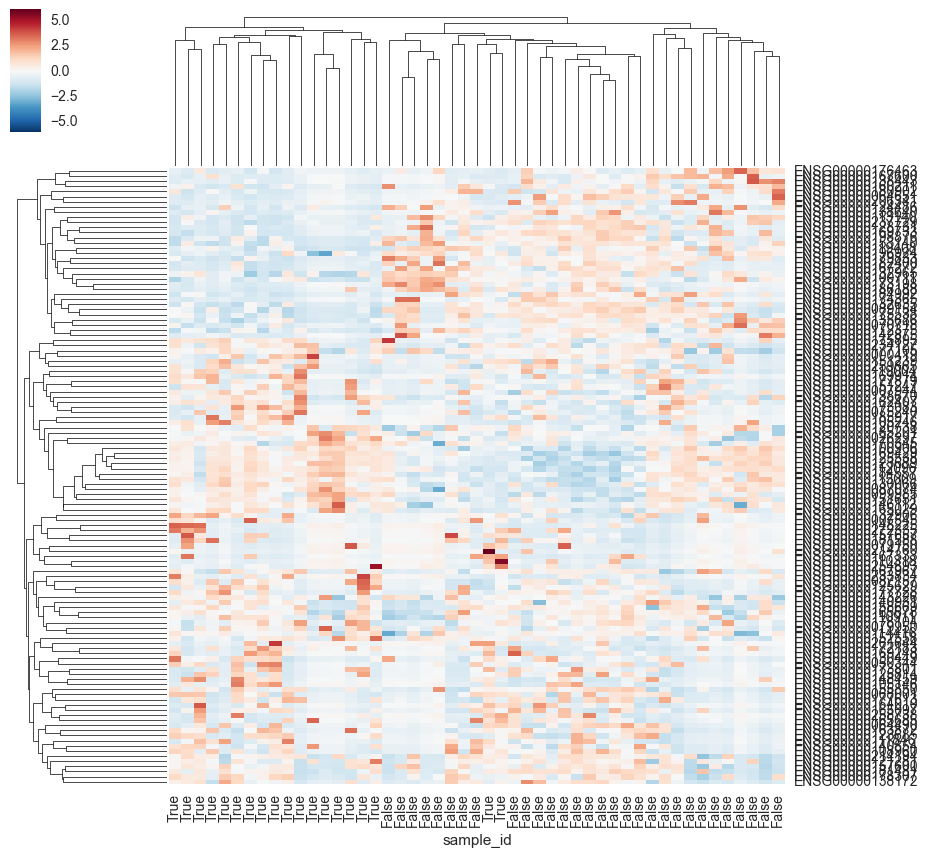

In [40]:
plot_cluster(df_train_top, dfm_train)

## +++++

In [ ]:
def plot_cluster(df, dfm):
    
    dfz = df.apply(zscore, axis=1)
    dfz = dfz.apply(zscore, axis=0)
    dfplot = dfz.T

    dfplot = dfplot.rename(columns={c: dfm.loc[c,'Pneum'] for c in dfplot.columns})

    dfplot.columns
    fig = sns.clustermap(dfplot, col_cluster=True)

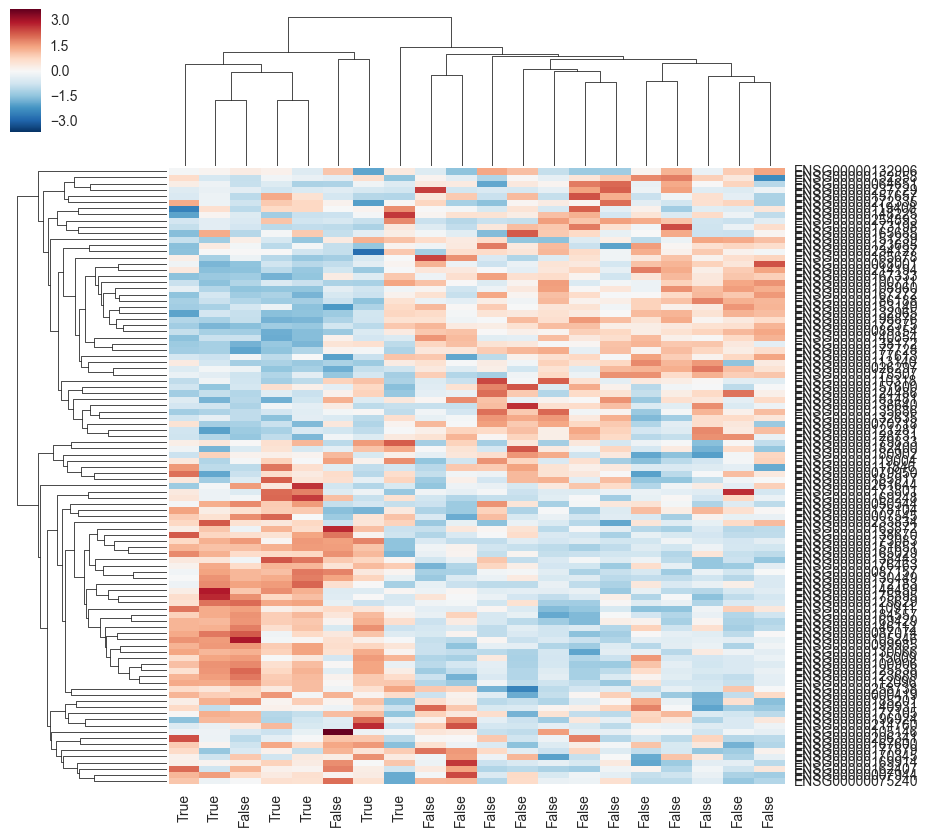

In [28]:
plot_cluster(df_test_top, dfm_test)

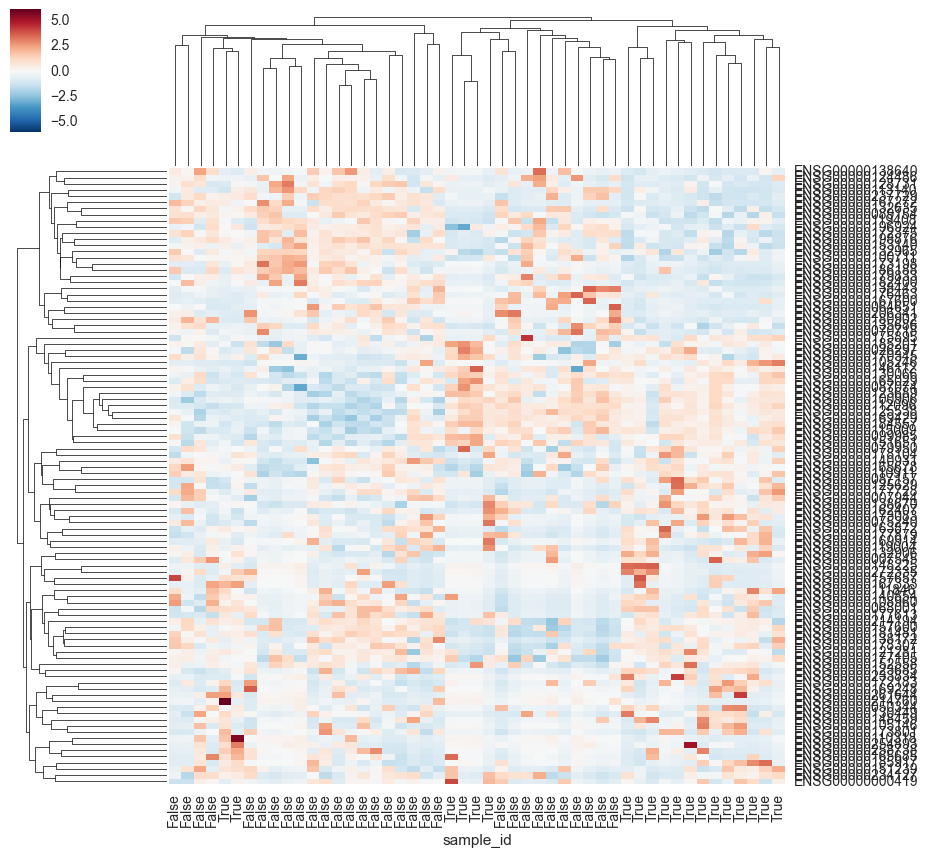

In [27]:
plot_cluster(df_train_top, dfm_train)

In [8]:
def get_random_stats(celltype, n_top_genes, norm=False, num_trials=20, rand=True):
    
    print "Celltype: ", celltype
    ### TRAINING
    #################
    
    # Get training data
    X, y, genes, df, dfm = geteven_xy(train_fpkm, meta, celltype=celltype, norm=norm)


    random_genes = np.random.choice(genes, n_top_genes)
    ### Build final model based on those genes (avoid overfitting with genes that are not common)
    
        ### TESTING
    ###############
    
    X_test, y_test, genes_test, df_test, dfm_test = geteven_xy(test_fpkm, 
                        test_meta, celltype=celltype, norm=norm)

    pos_accs = []
    neg_accs = []
    for n in tqdm(range(num_trials)):
        random_genes = np.random.choice(genes, n_top_genes)
        #print "Round ",n
        pls = PLSRegression(5, scale=True)
        X_train = np.array(df[random_genes])
        y_train = np.array(dfm['Pneum'])
        pls.fit(X_train, y_train)
        
        X_test = np.array(df_test[random_genes])
        #return X_test
        y_pred = pls.predict(X_test)

        neg_err = [float(abs(y_pred[i]-y_test[i])) for i in range(len(y_pred)) if y_test[i]==0]
        num_neg_correct = sum([(e < 0.5) for e in neg_err])
        neg_accuracy_test = float(num_neg_correct) / len(neg_err)
        neg_accs.append(neg_accuracy_test)
        #print "Negative test: {0:.2f} ({1}/{2}) ".format(neg_accuracy_test, num_neg_correct, len(neg_err))

        pos_err = [float(abs(y_pred[i]-y_test[i])) for i in range(len(y_pred)) if y_test[i]==1]
        num_pos_correct = sum([(e < 0.5) for e in pos_err])
        pos_accuracy_test = float(num_pos_correct) / len(pos_err)
        pos_accs.append(pos_accuracy_test)
        #print "Positive test: {0:.2f} ({1}/{2}) ".format(pos_accuracy_test, num_pos_correct, len(pos_err))

    return pos_accs, neg_accs#neg_accuracy_train, neg_accuracy_test, pos_accuracy_train, pos_accuracy_test

In [ ]:
cd163_neg = 1.0 #(5/5)
cd163_pos = 0.29 #(2/7)

In [26]:
top_genes_train, df_train_top, dfm_train, df_test_top, dfm_test = get_accuracy_stats(celltype='AM', n_top_genes=100, norm='zsc', random_genes=False)

Model =  AM
N_Top_Genes =  100
Normalization =  zsc
Q Squared: -0.456061700396 

Negative train: 0.60 (18/30) 
Positive train: 0.11 (2/19) 
Negative test: 0.93 (13/14) 
Positive test: 0.83 (5/6) 


## CD163

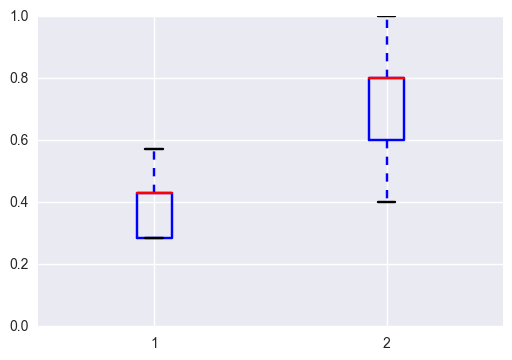

In [202]:
_ = plt.boxplot(X)

### AM, 100 genes

In [206]:
am = get_random_stats(celltype='AM', n_top_genes=100, norm='zsc', num_trials=25, rand=False)

Celltype:  AM


100%|██████████| 25/25 [00:00<00:00, 275.15it/s]

Test Df shape:
(20, 26081)


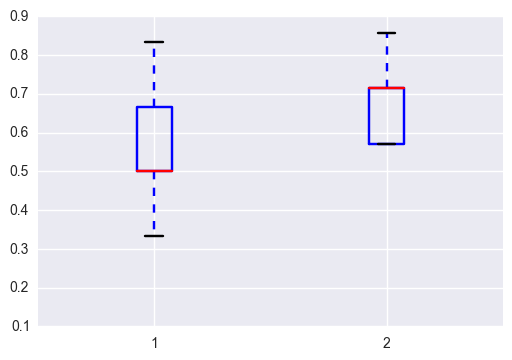

In [207]:
_ = plt.boxplot(am)

In [208]:
am_pos = 0.67
am_neg = 0.86

In [211]:
np.mean(am[0]), np.std(am[0]), np.mean(am[1]), np.std(am[1])

(0.53333333333333333,
 0.19436506316151003,
 0.66285714285714281,
 0.12538919004280966)

### testAM = get_accuracy_stats(celltype='AM', n_top_genes=20, norm='zsc')


## CD 163

In [162]:
get_accuracy_stats(celltype='CD163', n_top_genes=100, norm='zsc')

Model =  CD163
N_Top_Genes =  100
Normalization =  zsc
Q Squared: -0.133828299838 

Negative train: 0.97 (30/31) 
Positive train: 0.07 (1/15) 
Negative test: 1.00 (5/5) 
Positive test: 0.29 (2/7) 


In [150]:
get_accuracy_stats(celltype='CD163', n_top_genes=10, norm='zsc')

Model =  CD163
N_Top_Genes =  10
Normalization =  zsc
Q Squared: -0.111474285987 

Negative train: 0.90 (28/31) 
Positive train: 0.27 (4/15) 
Negative test: 0.80 (4/5) 
Positive test: 0.43 (3/7) 


(0.9032258064516129, 0.8, 0.26666666666666666, 0.42857142857142855)

In [113]:
get_accuracy_stats(celltype='AM', n_top_genes=20, norm='zsc')

Model =  CD163
N_Top_Genes =  20
Normalization =  zsc
Q Squared: -0.435658441702 

Negative train: 0.61 (19/31) 
Positive train: 0.47 (7/15) 
Negative test: 1.00 (5/5) 
Positive test: 0.43 (3/7) 


(0.6129032258064516, 1.0, 0.4666666666666667, 0.42857142857142855)

## AM

In [161]:
get_accuracy_stats(celltype='AM', n_top_genes=100, norm='zsc')

Model =  AM
N_Top_Genes =  100
Normalization =  zsc
Q Squared: -0.328150650597 

Negative train: 0.70 (21/30) 
Positive train: 0.11 (2/19) 
Negative test: 0.86 (12/14) 
Positive test: 0.67 (4/6) 


In [174]:
get_accuracy_stats(celltype='AM', n_top_genes=100, norm='zsc', random_genes=True)

Model =  AM
N_Top_Genes =  100
Normalization =  zsc
Q Squared: -0.328150650597 

Negative train: 0.70 (21/30) 
Positive train: 0.11 (2/19) 

Genes for testing are RANDOM

Negative test: 0.71 (10/14) 
Positive test: 0.67 (4/6) 


In [152]:
get_accuracy_stats(celltype='AM', n_top_genes=20, norm='zsc')

Model =  AM
N_Top_Genes =  20
Normalization =  zsc
Q Squared: -0.242018122858 

Negative train: 0.70 (21/30) 
Positive train: 0.26 (5/19) 
Negative test: 0.86 (12/14) 
Positive test: 0.50 (3/6) 


(0.7, 0.8571428571428571, 0.2631578947368421, 0.5)

In [158]:
get_accuracy_stats(celltype='AM', n_top_genes=10, norm='zsc')

Model =  AM
N_Top_Genes =  10
Normalization =  zsc
Q Squared: -0.137395018647 

Negative train: 0.73 (22/30) 
Positive train: 0.37 (7/19) 
Negative test: 0.57 (8/14) 
Positive test: 0.33 (2/6) 


In [132]:
get_accuracy_stats(celltype='AM', n_top_genes=5, norm='zsc', random_genes=True)

Model =  AM
N_Top_Genes =  5
Normalization =  zsc
Q Squared: -0.103670427815 

Negative train: 0.77 (23/30) 
Positive train: 0.58 (11/19) 

Genes for testing are RANDOM



KeyError: "['ENSG00000166710' 'ENSG00000210112' 'ENSG00000210196'] not in index"

## ========

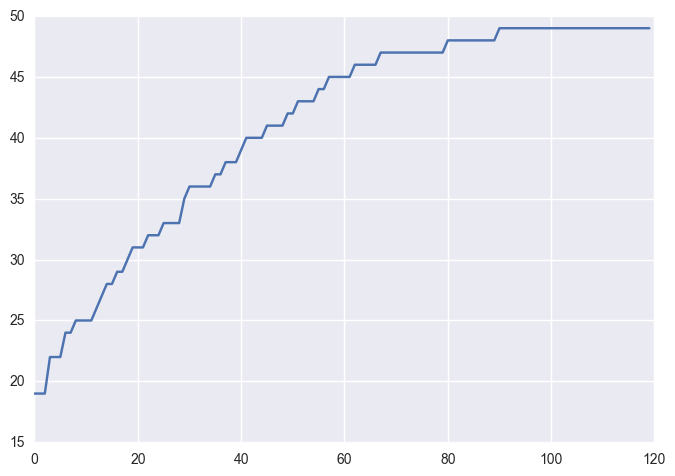

In [153]:
plt.plot(sorted([i[1] for i in c.most_common(120)]))

In [54]:
#determine the best number of genes for the training model
def plotQ2(r=np.arange(10,205,5), celltype=False, z=True):
    Q2s = []
    for n_top_genes in tqdm(r):
        X, y, genes, df, dfm = geteven_xy(train_fpkm, meta, celltype=celltype, norm='zsc')
        neg_err, pos_err, Q2, neg_corr, pos_corr, vip_inds = calc_metrics(X, y, 
                                                        n_pcs=5, n_top_genes=n_top_genes)
        Q2s.append(Q2)
    plt.plot(r, Q2s)
    return None #Q2s

100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


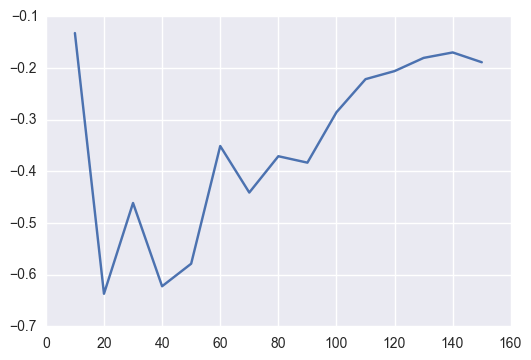

In [133]:
plotQ2(r=np.arange(10,155,10), celltype='AM')

100%|██████████| 29/29 [00:39<00:00,  1.39s/it]


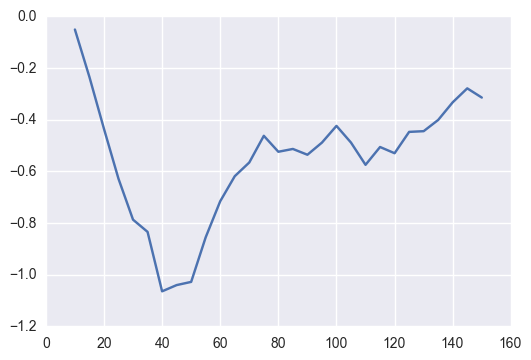

In [134]:
plotQ2(r=np.arange(10,155,5), celltype='CD163')

# Uneven only

In [22]:
testAM = get_accuracy_stats(celltype='AM', n_top_genes=100, norm='zsc')


In [23]:
testAM

(0.21052631578947367, 0.7857142857142857, 0.6, 0.3333333333333333)

In [24]:
test163 = get_accuracy_stats(celltype='CD163', n_top_genes=100, norm='zsc')


In [25]:
test163

(0.4666666666666667, 0.8, 0.8387096774193549, 0.2857142857142857)

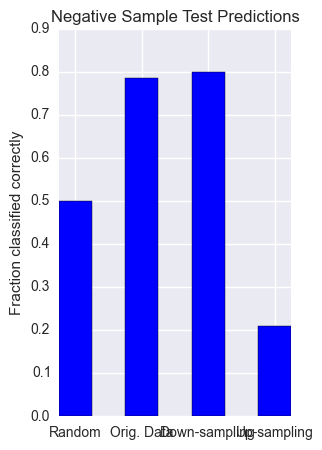

In [29]:

width = 0.5
plt.figure(num=None, figsize=(3, 5), dpi=80, facecolor='w', edgecolor='k')
data = [0.5, testAM[1], test163[1], testAM[0]]
index = np.arange(len(data))
labels = ('Random', 'Orig. Data', 'Down-sampling', 'Up-sampling')

plt.bar(index, data)
plt.xticks(index + width / 2, labels)
plt.ylabel("Fraction classified correctly")
plt.title("Negative Sample Test Predictions")

In [18]:
def calc_metrics(X, y, n_pcs, n_top_genes):
    
    n_samples = len(X)
    pred = []
    vip_inds_all = []
    #print X.shape, y.shape
    
    ### Leave-One-Out Cross-validation
    
    for sample in range(n_samples):
        samples = range(n_samples)
        samples.remove(sample)
        X_t = X[(samples)]
        y_t = y[(samples)]
        #print X_t.shape    
        
        ### Get VIPs for model built without the LOO sample
        plsv = PLSRegression(5, scale=False)
        plsv.fit(X_t, y_t)
        vips = vipp(X_t, y_t, plsv.x_scores_, plsv.x_weights_)
        vips = [float(v) for v in vips]
        vip_inds = np.argsort(vips)[::-1][:n_top_genes]
        vip_inds_all.append(vip_inds)
        
        ### Xn takes the original X to get the loo sample
        Xn = X.T[vip_inds].T
        loo_sample = Xn[sample]
        loo_sample = np.array(loo_sample).reshape((1, -1))
        
        ### Filter the samples 
        X_tn = X_t.T[vip_inds].T
        #print X_tn.shape
        pls = PLSRegression(n_pcs, scale=False)
        pls.fit(X_tn, y_t)

        pred.append(float(pls.predict(loo_sample)))

    # Calculate metrics
    ### Q squared
    num = sum([float((pred[i] - y[i]))**2 for i in range(len(pred))])
    den = sum([(y[i] - np.mean(y))**2 for i in range(len(pred))])
    Q2 = float(1 - num/den)

    ### Prediction error
    errs = [abs(float((pred[i] - y[i]))) for i in range(len(pred))]
 
    ### Percent correct for neg and pos Pneumonia
    neg_err = [errs[i] for i in range(len(errs)) if y[i]==0]  
    neg_corr = [e < 0.5 for e in neg_err]   
    neg_corr = float(sum(neg_corr)) / len(neg_err)

    
    pos_err = [errs[i] for i in range(len(errs)) if y[i]==1]
    pos_corr = [e < 0.5 for e in pos_err]
    pos_corr = float(sum(pos_corr)) / len(pos_err)
    

    #print "num: {0: .3f}, den: {1: .3f}, 
    #print "Q^2: {0: .3f}".format(Q2)
    
    return neg_err, pos_err, Q2, neg_corr, pos_corr, vip_inds_all
    #return [float(abs(pred[p] - y[p])) for p in range(len(pred))]

In [17]:
def vipp(x, y, t, w):

    """
    From original MATLAB code
    See https://code.google.com/p/carspls/

    #+++ vip=vipp(x,y,t,w);
    #+++ t: scores, which can be obtained by pls_nipals.m
    #+++ w: weight, which can be obtained by pls_nipals.m
    #+++ to calculate the vip for each variable to the response;
    #+++ vip=sqrt(p*q/s);
    """
    #initializing
    [p, h] = w.shape
    co = np.matrix(np.zeros([1, h]))

    # Calculate s
    for ii in range(h):
        corr = np.corrcoef(y, t[:, ii], rowvar=0)
        co[0, ii] = corr[0, 1]**2
    s = np.sum(co)

    # Calculate q
    # This has been linearized to replace the original nested for loop
    w_power = np.power(w, 2)
    d = np.multiply(w_power, co)
    q = np.sum(d, 1)
    vip = np.sqrt(p*q/s)
    return vip

In [75]:
def calc_Q2_kftest(X, y, k=5, n_rand=10, n_pcs=5, method='PLSR'):
    n_samples = len(X)
    pred = []
    Q2s = []
    for ki in range(n_rand):
        sample_ind = range(n_samples)
        withheld_samples = random.sample(sample_ind, k)
        lo_samples = X[withheld_samples]
        for s in withheld_samples:
            sample_ind.remove(s)
        X_t = X[(sample_ind)]
        y_t = y[(sample_ind)]
        if method=='PLSR':
            model = PLSRegression(n_pcs, scale=False)
        elif method=='RF':
            model = RandomForestClassifier()
        elif method=='SVM':
            model = SVC()
        else:
            print "Method not found"
        model.fit(X_t, y_t)

        for s in withheld_samples:
            pred.append(float(model.predict(X[s])))
        #Eprint "samples", withheld_samples
        #Eprint "pred", pred
        num = sum([(pred[i] - y[s])**2 for i, s in enumerate(withheld_samples)])
        den = sum([(y[s] - np.mean(y[withheld_samples]))**2 for s in withheld_samples])
        Q2 = float(1- num/den)
        Q2s.append(Q2)
    print "Q^2: mean={0: .2f}, std={1: .2f}".format(np.mean(Q2s),np.std(Q2s))
    #return [float(abs(pred[p] - y[p])) for p in range(len(pred))]